In [104]:
import torch 
from torch import nn 
from torchvision import transforms
from torchvision.datasets import Omniglot
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from torch.nn import functional as F
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import models

In [105]:
augmentation1 = transforms.Compose([
    transforms.RandomResizedCrop(28, scale=(0.8, 1.0)),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

augmentation2 = transforms.Compose([
    transforms.RandomResizedCrop(28, scale=(0.8, 1.0)),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [106]:
class BYOLDataset(Dataset):
    def __init__(self, base_dataset, transform1, transform2):
        self.base_dataset = base_dataset
        self.transform1 = transform1
        self.transform2 = transform2

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        img, _ = self.base_dataset[idx] 
        x1 = self.transform1(img)
        x2 = self.transform2(img)
        return x1, x2

In [107]:
base_dataset = Omniglot(
    root='./data',
    background=True,
    download=True,
    transform=None  
)

byol_dataset = BYOLDataset(base_dataset, augmentation1, augmentation2)
dataloader = torch.utils.data.DataLoader(byol_dataset, batch_size=128, shuffle=True)

Files already downloaded and verified


In [108]:
data_iter = iter(dataloader)
x1, x2 = next(data_iter)
print(x1.shape) 
print(x2.shape) 


torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])


In [109]:
data_iter = iter(dataloader)
images, labels = next(data_iter)
images.shape

torch.Size([128, 1, 28, 28])

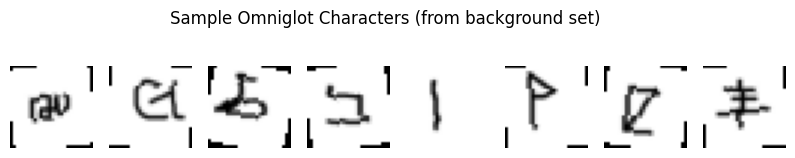

In [110]:
plt.figure(figsize=(10, 2))
for i in range(8):
    plt.subplot(1, 8, i+1)
    plt.imshow(images[i].squeeze(0).numpy(), cmap='gray')
    plt.axis('off')
plt.suptitle("Sample Omniglot Characters (from background set)")
plt.show()

In [111]:
class Encoder(nn.Module):
    def __init__(self, hidden_dim=64, out_dim=64):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, hidden_dim, kernel_size=3, padding=1),  # 28x28
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(),
            nn.MaxPool2d(2),  # -> 14x14

            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(),
            nn.MaxPool2d(2),  # -> 7x7

            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(),
            nn.MaxPool2d(2),  # -> 3x3

            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))  # -> 1x1
        )
        self.fc = nn.Linear(hidden_dim, out_dim)

    def forward(self, x):
        x = self.encoder(x)          # Shape: (B, hidden_dim, 1, 1)
        x = x.view(x.size(0), -1)    # Flatten to (B, hidden_dim)
        return self.fc(x)           

In [112]:
class MLP(nn.Module):
    def __init__(self, in_dim, hidden_dim=128, out_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, out_dim)
        )

    def forward(self, x):
        return self.net(x)


In [113]:
class OnlineNetwork(nn.Module):
    def __init__(self, encoder, feature_dim=64, proj_hidden_dim=128, proj_out_dim=128):
        super().__init__()
        self.encoder = encoder
        self.projector = MLP(feature_dim, proj_hidden_dim, proj_out_dim)
        self.predictor = MLP(proj_out_dim, proj_hidden_dim // 2, proj_out_dim)

    def forward(self, x):
        features = self.encoder(x)
        projections = self.projector(features)
        predictions = self.predictor(projections)
        return predictions, projections

In [114]:
class TargetNetwork(nn.Module):
    def __init__(self, encoder, feature_dim=64, proj_hidden_dim=256, proj_out_dim=256):
        super().__init__()
        self.encoder = encoder
        self.projector = MLP(feature_dim, proj_hidden_dim, proj_out_dim)

    def forward(self, x):
        features = self.encoder(x)
        projections = self.projector(features)
        return projections


In [115]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [116]:
encoder = Encoder()

online_net = OnlineNetwork(encoder, feature_dim=64, proj_hidden_dim=128, proj_out_dim=128)
target_net = TargetNetwork(encoder, feature_dim=64, proj_hidden_dim=128, proj_out_dim=128)
online_net.to(device)
target_net.to(device)

TargetNetwork(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU()
      (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): BatchNorm2d(64, eps=1e-05, mo

In [117]:
def loss_fn(p, z):
    p = F.normalize(p, dim=-1)
    z = F.normalize(z.detach(), dim=-1)
    return 2 - 2 * (p * z).sum(dim=-1).mean()

In [118]:
@torch.no_grad()
def update_target_network(online_net, target_net, beta=0.996):
    for param_o, param_t in zip(online_net.parameters(), target_net.parameters()):
        param_t.data = beta * param_t.data + (1 - beta) * param_o.data

In [119]:
# Count parameters
def count_parameters(model):
    """Count the number of trainable parameters in a model"""
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params

def count_parameters_by_layer(model):
    """Count parameters by layer and show detailed breakdown"""
    total_params = 0
    trainable_params = 0
    
    print("Parameter count by layer:")
    print("-" * 50)
    
    for name, param in model.named_parameters():
        param_count = param.numel()
        total_params += param_count
        if param.requires_grad:
            trainable_params += param_count
            print(f"{name}: {param_count:,} parameters (trainable)")
        else:
            print(f"{name}: {param_count:,} parameters (frozen)")
    
    print("-" * 50)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    print(f"Frozen parameters: {total_params - trainable_params:,}")
    
    return total_params, trainable_params

# Count parameters for online network
print("ONLINE NETWORK PARAMETER COUNT:")
print("=" * 50)
total_params, trainable_params = count_parameters_by_layer(online_net)

# Also show a simple count
simple_count = count_parameters(online_net)
print(f"\nSimple parameter count: {simple_count:,}")

# Convert to millions for easier reading
print(f"Parameters in millions: {simple_count / 1e6:.2f}M")

ONLINE NETWORK PARAMETER COUNT:
Parameter count by layer:
--------------------------------------------------
encoder.encoder.0.weight: 576 parameters (trainable)
encoder.encoder.0.bias: 64 parameters (trainable)
encoder.encoder.1.weight: 64 parameters (trainable)
encoder.encoder.1.bias: 64 parameters (trainable)
encoder.encoder.4.weight: 36,864 parameters (trainable)
encoder.encoder.4.bias: 64 parameters (trainable)
encoder.encoder.5.weight: 64 parameters (trainable)
encoder.encoder.5.bias: 64 parameters (trainable)
encoder.encoder.8.weight: 36,864 parameters (trainable)
encoder.encoder.8.bias: 64 parameters (trainable)
encoder.encoder.9.weight: 64 parameters (trainable)
encoder.encoder.9.bias: 64 parameters (trainable)
encoder.encoder.12.weight: 36,864 parameters (trainable)
encoder.encoder.12.bias: 64 parameters (trainable)
encoder.encoder.13.weight: 64 parameters (trainable)
encoder.encoder.13.bias: 64 parameters (trainable)
encoder.fc.weight: 4,096 parameters (trainable)
encoder.fc

In [120]:
lr = 1e-5
weight_decay = 1e-6  
epochs = 100

optimizer = torch.optim.Adam(online_net.parameters(), lr=lr, weight_decay=weight_decay)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', patience=5, verbose=True
)

online_net = online_net.to(device)
target_net = target_net.to(device)
target_net.eval()

best_loss = float('inf')
epoch_losses = [] 

for epoch in range(epochs):
    online_net.train()
    total_loss = 0
    loop = tqdm(dataloader, desc=f"Epoch [{epoch+1}/{epochs}]")

    for x1, x2 in loop:
        x1, x2 = x1.to(device), x2.to(device)

        optimizer.zero_grad()

        # Online forward
        p1, z1 = online_net(x1)

        with torch.no_grad():
            z2 = target_net(x2)

        loss1 = loss_fn(p1, z2)

        # Second view
        p2, z2_online = online_net(x2)

        with torch.no_grad():
            z1_target = target_net(x1)

        loss2 = loss_fn(p2, z1_target)

        # Total loss
        loss = (loss1 + loss2) / 2
        loss.backward()
        optimizer.step()

        # Update target net
        update_target_network(online_net, target_net, beta=0.996)

        total_loss += loss.item()
        avg_loss = total_loss / (loop.n + 1)
        loop.set_postfix(loss=avg_loss)

    # Epoch average loss
    total_loss_epoch = total_loss / len(dataloader)
    epoch_losses.append(total_loss_epoch)  # Save for plotting
    print(f"Epoch {epoch+1} Final Avg Loss: {total_loss_epoch:.4f}")

    # Step the scheduler
    scheduler.step(total_loss_epoch)

    # Save best model
    if total_loss_epoch < best_loss:
        best_loss = total_loss_epoch
        torch.save(target_net.encoder.state_dict(), 'best_model.pth')

print("\nBest Validation Loss:", best_loss)


Epoch [1/100]: 100%|██████████| 151/151 [00:28<00:00,  5.25it/s, loss=1.82]


Epoch 1 Final Avg Loss: 1.8172


Epoch [2/100]: 100%|██████████| 151/151 [00:28<00:00,  5.25it/s, loss=1.59]


Epoch 2 Final Avg Loss: 1.5883


Epoch [3/100]: 100%|██████████| 151/151 [00:29<00:00,  5.20it/s, loss=1.35]


Epoch 3 Final Avg Loss: 1.3531


Epoch [4/100]: 100%|██████████| 151/151 [00:28<00:00,  5.32it/s, loss=1.14]


Epoch 4 Final Avg Loss: 1.1391


Epoch [5/100]: 100%|██████████| 151/151 [00:29<00:00,  5.20it/s, loss=0.958]


Epoch 5 Final Avg Loss: 0.9577


Epoch [6/100]: 100%|██████████| 151/151 [00:27<00:00,  5.40it/s, loss=0.807]


Epoch 6 Final Avg Loss: 0.8072


Epoch [7/100]: 100%|██████████| 151/151 [00:31<00:00,  4.86it/s, loss=0.676]


Epoch 7 Final Avg Loss: 0.6757


Epoch [8/100]: 100%|██████████| 151/151 [00:36<00:00,  4.13it/s, loss=0.563]


Epoch 8 Final Avg Loss: 0.5625


Epoch [9/100]: 100%|██████████| 151/151 [00:29<00:00,  5.08it/s, loss=0.468]


Epoch 9 Final Avg Loss: 0.4676


Epoch [10/100]: 100%|██████████| 151/151 [00:29<00:00,  5.09it/s, loss=0.39] 


Epoch 10 Final Avg Loss: 0.3900


Epoch [11/100]: 100%|██████████| 151/151 [00:29<00:00,  5.17it/s, loss=0.325]


Epoch 11 Final Avg Loss: 0.3246


Epoch [12/100]: 100%|██████████| 151/151 [00:29<00:00,  5.06it/s, loss=0.27] 


Epoch 12 Final Avg Loss: 0.2695


Epoch [13/100]: 100%|██████████| 151/151 [00:31<00:00,  4.86it/s, loss=0.227]


Epoch 13 Final Avg Loss: 0.2270


Epoch [14/100]: 100%|██████████| 151/151 [00:30<00:00,  4.93it/s, loss=0.193]


Epoch 14 Final Avg Loss: 0.1926


Epoch [15/100]: 100%|██████████| 151/151 [00:30<00:00,  4.92it/s, loss=0.163]


Epoch 15 Final Avg Loss: 0.1628


Epoch [16/100]: 100%|██████████| 151/151 [00:33<00:00,  4.51it/s, loss=0.141]


Epoch 16 Final Avg Loss: 0.1412


Epoch [17/100]: 100%|██████████| 151/151 [00:32<00:00,  4.60it/s, loss=0.122]


Epoch 17 Final Avg Loss: 0.1219


Epoch [18/100]: 100%|██████████| 151/151 [00:31<00:00,  4.84it/s, loss=0.105]


Epoch 18 Final Avg Loss: 0.1047


Epoch [19/100]: 100%|██████████| 151/151 [00:29<00:00,  5.06it/s, loss=0.0919]


Epoch 19 Final Avg Loss: 0.0919


Epoch [20/100]: 100%|██████████| 151/151 [00:29<00:00,  5.06it/s, loss=0.0855]


Epoch 20 Final Avg Loss: 0.0855


Epoch [21/100]: 100%|██████████| 151/151 [00:31<00:00,  4.79it/s, loss=0.076] 


Epoch 21 Final Avg Loss: 0.0760


Epoch [22/100]: 100%|██████████| 151/151 [00:29<00:00,  5.10it/s, loss=0.0682]


Epoch 22 Final Avg Loss: 0.0682


Epoch [23/100]: 100%|██████████| 151/151 [00:30<00:00,  5.02it/s, loss=0.0635]


Epoch 23 Final Avg Loss: 0.0635


Epoch [24/100]: 100%|██████████| 151/151 [00:28<00:00,  5.23it/s, loss=0.0592]


Epoch 24 Final Avg Loss: 0.0592


Epoch [25/100]: 100%|██████████| 151/151 [00:28<00:00,  5.28it/s, loss=0.0556]


Epoch 25 Final Avg Loss: 0.0556


Epoch [26/100]: 100%|██████████| 151/151 [00:28<00:00,  5.24it/s, loss=0.0519]


Epoch 26 Final Avg Loss: 0.0519


Epoch [27/100]: 100%|██████████| 151/151 [00:28<00:00,  5.39it/s, loss=0.0491]


Epoch 27 Final Avg Loss: 0.0491


Epoch [28/100]: 100%|██████████| 151/151 [00:28<00:00,  5.35it/s, loss=0.0464]


Epoch 28 Final Avg Loss: 0.0464


Epoch [29/100]: 100%|██████████| 151/151 [00:29<00:00,  5.18it/s, loss=0.045] 


Epoch 29 Final Avg Loss: 0.0450


Epoch [30/100]: 100%|██████████| 151/151 [00:28<00:00,  5.24it/s, loss=0.0429]


Epoch 30 Final Avg Loss: 0.0429


Epoch [31/100]: 100%|██████████| 151/151 [00:28<00:00,  5.22it/s, loss=0.0405]


Epoch 31 Final Avg Loss: 0.0405


Epoch [32/100]: 100%|██████████| 151/151 [00:28<00:00,  5.24it/s, loss=0.0392]


Epoch 32 Final Avg Loss: 0.0392


Epoch [33/100]: 100%|██████████| 151/151 [00:28<00:00,  5.26it/s, loss=0.0379]


Epoch 33 Final Avg Loss: 0.0379


Epoch [34/100]: 100%|██████████| 151/151 [00:29<00:00,  5.18it/s, loss=0.0371]


Epoch 34 Final Avg Loss: 0.0371


Epoch [35/100]: 100%|██████████| 151/151 [00:29<00:00,  5.04it/s, loss=0.0355]


Epoch 35 Final Avg Loss: 0.0355


Epoch [36/100]: 100%|██████████| 151/151 [00:29<00:00,  5.06it/s, loss=0.0337]


Epoch 36 Final Avg Loss: 0.0337


Epoch [37/100]: 100%|██████████| 151/151 [00:29<00:00,  5.04it/s, loss=0.0333]


Epoch 37 Final Avg Loss: 0.0333


Epoch [38/100]: 100%|██████████| 151/151 [00:31<00:00,  4.82it/s, loss=0.0322]


Epoch 38 Final Avg Loss: 0.0322


Epoch [39/100]: 100%|██████████| 151/151 [00:30<00:00,  4.88it/s, loss=0.0308]


Epoch 39 Final Avg Loss: 0.0308


Epoch [40/100]: 100%|██████████| 151/151 [00:31<00:00,  4.83it/s, loss=0.0299]


Epoch 40 Final Avg Loss: 0.0299


Epoch [41/100]: 100%|██████████| 151/151 [00:32<00:00,  4.63it/s, loss=0.0287]


Epoch 41 Final Avg Loss: 0.0287


Epoch [42/100]: 100%|██████████| 151/151 [00:31<00:00,  4.82it/s, loss=0.0279]


Epoch 42 Final Avg Loss: 0.0279


Epoch [43/100]: 100%|██████████| 151/151 [00:32<00:00,  4.60it/s, loss=0.0274]


Epoch 43 Final Avg Loss: 0.0274


Epoch [44/100]: 100%|██████████| 151/151 [00:31<00:00,  4.72it/s, loss=0.0265]


Epoch 44 Final Avg Loss: 0.0265


Epoch [45/100]: 100%|██████████| 151/151 [00:29<00:00,  5.10it/s, loss=0.0262]


Epoch 45 Final Avg Loss: 0.0262


Epoch [46/100]: 100%|██████████| 151/151 [00:28<00:00,  5.27it/s, loss=0.0262]


Epoch 46 Final Avg Loss: 0.0262


Epoch [47/100]: 100%|██████████| 151/151 [00:30<00:00,  5.03it/s, loss=0.025] 


Epoch 47 Final Avg Loss: 0.0250


Epoch [48/100]: 100%|██████████| 151/151 [00:29<00:00,  5.10it/s, loss=0.0251]


Epoch 48 Final Avg Loss: 0.0251


Epoch [49/100]: 100%|██████████| 151/151 [00:29<00:00,  5.16it/s, loss=0.0252]


Epoch 49 Final Avg Loss: 0.0252


Epoch [50/100]: 100%|██████████| 151/151 [00:28<00:00,  5.27it/s, loss=0.0247]


Epoch 50 Final Avg Loss: 0.0247


Epoch [51/100]: 100%|██████████| 151/151 [00:29<00:00,  5.15it/s, loss=0.0241]


Epoch 51 Final Avg Loss: 0.0241


Epoch [52/100]: 100%|██████████| 151/151 [00:28<00:00,  5.34it/s, loss=0.0235]


Epoch 52 Final Avg Loss: 0.0235


Epoch [53/100]: 100%|██████████| 151/151 [00:28<00:00,  5.21it/s, loss=0.0236]


Epoch 53 Final Avg Loss: 0.0236


Epoch [54/100]: 100%|██████████| 151/151 [00:27<00:00,  5.42it/s, loss=0.0232]


Epoch 54 Final Avg Loss: 0.0232


Epoch [55/100]: 100%|██████████| 151/151 [00:27<00:00,  5.40it/s, loss=0.023] 


Epoch 55 Final Avg Loss: 0.0230


Epoch [56/100]: 100%|██████████| 151/151 [00:28<00:00,  5.26it/s, loss=0.0227]


Epoch 56 Final Avg Loss: 0.0227


Epoch [57/100]: 100%|██████████| 151/151 [00:28<00:00,  5.30it/s, loss=0.0223]


Epoch 57 Final Avg Loss: 0.0223


Epoch [58/100]: 100%|██████████| 151/151 [00:28<00:00,  5.36it/s, loss=0.0225]


Epoch 58 Final Avg Loss: 0.0225


Epoch [59/100]: 100%|██████████| 151/151 [00:28<00:00,  5.24it/s, loss=0.022] 


Epoch 59 Final Avg Loss: 0.0220


Epoch [60/100]: 100%|██████████| 151/151 [00:28<00:00,  5.36it/s, loss=0.0222]


Epoch 60 Final Avg Loss: 0.0222


Epoch [61/100]: 100%|██████████| 151/151 [00:28<00:00,  5.36it/s, loss=0.0223]


Epoch 61 Final Avg Loss: 0.0223


Epoch [62/100]: 100%|██████████| 151/151 [00:28<00:00,  5.32it/s, loss=0.0218]


Epoch 62 Final Avg Loss: 0.0218


Epoch [63/100]: 100%|██████████| 151/151 [00:28<00:00,  5.28it/s, loss=0.0216]


Epoch 63 Final Avg Loss: 0.0216


Epoch [64/100]: 100%|██████████| 151/151 [00:28<00:00,  5.39it/s, loss=0.0215]


Epoch 64 Final Avg Loss: 0.0215


Epoch [65/100]: 100%|██████████| 151/151 [00:28<00:00,  5.23it/s, loss=0.0216]


Epoch 65 Final Avg Loss: 0.0216


Epoch [66/100]: 100%|██████████| 151/151 [00:28<00:00,  5.37it/s, loss=0.0216]


Epoch 66 Final Avg Loss: 0.0216


Epoch [67/100]: 100%|██████████| 151/151 [00:28<00:00,  5.22it/s, loss=0.021] 


Epoch 67 Final Avg Loss: 0.0210


Epoch [68/100]: 100%|██████████| 151/151 [00:27<00:00,  5.44it/s, loss=0.021] 


Epoch 68 Final Avg Loss: 0.0210


Epoch [69/100]: 100%|██████████| 151/151 [00:28<00:00,  5.30it/s, loss=0.0213]


Epoch 69 Final Avg Loss: 0.0213


Epoch [70/100]: 100%|██████████| 151/151 [00:27<00:00,  5.47it/s, loss=0.0207]


Epoch 70 Final Avg Loss: 0.0207


Epoch [71/100]: 100%|██████████| 151/151 [00:28<00:00,  5.23it/s, loss=0.0211]


Epoch 71 Final Avg Loss: 0.0211


Epoch [72/100]: 100%|██████████| 151/151 [00:28<00:00,  5.32it/s, loss=0.0213]


Epoch 72 Final Avg Loss: 0.0213


Epoch [73/100]: 100%|██████████| 151/151 [00:28<00:00,  5.24it/s, loss=0.0209]


Epoch 73 Final Avg Loss: 0.0209


Epoch [74/100]: 100%|██████████| 151/151 [00:29<00:00,  5.21it/s, loss=0.0209]


Epoch 74 Final Avg Loss: 0.0209


Epoch [75/100]: 100%|██████████| 151/151 [00:28<00:00,  5.27it/s, loss=0.0205]


Epoch 75 Final Avg Loss: 0.0205


Epoch [76/100]: 100%|██████████| 151/151 [00:28<00:00,  5.32it/s, loss=0.0208]


Epoch 76 Final Avg Loss: 0.0208


Epoch [77/100]: 100%|██████████| 151/151 [00:29<00:00,  5.19it/s, loss=0.0205]


Epoch 77 Final Avg Loss: 0.0205


Epoch [78/100]: 100%|██████████| 151/151 [00:29<00:00,  5.18it/s, loss=0.0206]


Epoch 78 Final Avg Loss: 0.0206


Epoch [79/100]: 100%|██████████| 151/151 [00:31<00:00,  4.75it/s, loss=0.0203]


Epoch 79 Final Avg Loss: 0.0203


Epoch [80/100]: 100%|██████████| 151/151 [00:32<00:00,  4.71it/s, loss=0.0205]


Epoch 80 Final Avg Loss: 0.0205


Epoch [81/100]: 100%|██████████| 151/151 [00:31<00:00,  4.76it/s, loss=0.0201]


Epoch 81 Final Avg Loss: 0.0201


Epoch [82/100]: 100%|██████████| 151/151 [00:31<00:00,  4.72it/s, loss=0.0206]


Epoch 82 Final Avg Loss: 0.0206


Epoch [83/100]: 100%|██████████| 151/151 [00:32<00:00,  4.68it/s, loss=0.0204]


Epoch 83 Final Avg Loss: 0.0204


Epoch [84/100]: 100%|██████████| 151/151 [00:31<00:00,  4.74it/s, loss=0.0201]


Epoch 84 Final Avg Loss: 0.0201


Epoch [85/100]: 100%|██████████| 151/151 [00:32<00:00,  4.63it/s, loss=0.02]  


Epoch 85 Final Avg Loss: 0.0200


Epoch [86/100]: 100%|██████████| 151/151 [00:32<00:00,  4.63it/s, loss=0.0202]


Epoch 86 Final Avg Loss: 0.0202


Epoch [87/100]: 100%|██████████| 151/151 [00:32<00:00,  4.60it/s, loss=0.0202]


Epoch 87 Final Avg Loss: 0.0202


Epoch [88/100]: 100%|██████████| 151/151 [00:32<00:00,  4.65it/s, loss=0.02]  


Epoch 88 Final Avg Loss: 0.0200


Epoch [89/100]: 100%|██████████| 151/151 [00:33<00:00,  4.57it/s, loss=0.0209]


Epoch 89 Final Avg Loss: 0.0209


Epoch [90/100]: 100%|██████████| 151/151 [00:30<00:00,  5.00it/s, loss=0.0207]


Epoch 90 Final Avg Loss: 0.0207


Epoch [91/100]: 100%|██████████| 151/151 [00:33<00:00,  4.50it/s, loss=0.0198]


Epoch 91 Final Avg Loss: 0.0198


Epoch [92/100]: 100%|██████████| 151/151 [00:32<00:00,  4.59it/s, loss=0.0203]


Epoch 92 Final Avg Loss: 0.0203


Epoch [93/100]: 100%|██████████| 151/151 [00:32<00:00,  4.64it/s, loss=0.0203]


Epoch 93 Final Avg Loss: 0.0203


Epoch [94/100]: 100%|██████████| 151/151 [00:32<00:00,  4.64it/s, loss=0.0206]


Epoch 94 Final Avg Loss: 0.0206


Epoch [95/100]: 100%|██████████| 151/151 [00:32<00:00,  4.66it/s, loss=0.021] 


Epoch 95 Final Avg Loss: 0.0210


Epoch [96/100]: 100%|██████████| 151/151 [00:32<00:00,  4.61it/s, loss=0.0207]


Epoch 96 Final Avg Loss: 0.0207


Epoch [97/100]: 100%|██████████| 151/151 [00:33<00:00,  4.50it/s, loss=0.0207]


Epoch 97 Final Avg Loss: 0.0207


Epoch [98/100]: 100%|██████████| 151/151 [00:32<00:00,  4.70it/s, loss=0.0209]


Epoch 98 Final Avg Loss: 0.0209


Epoch [99/100]: 100%|██████████| 151/151 [00:32<00:00,  4.63it/s, loss=0.021] 


Epoch 99 Final Avg Loss: 0.0210


Epoch [100/100]: 100%|██████████| 151/151 [00:32<00:00,  4.68it/s, loss=0.0207]

Epoch 100 Final Avg Loss: 0.0207

Best Validation Loss: 0.019844377277702684


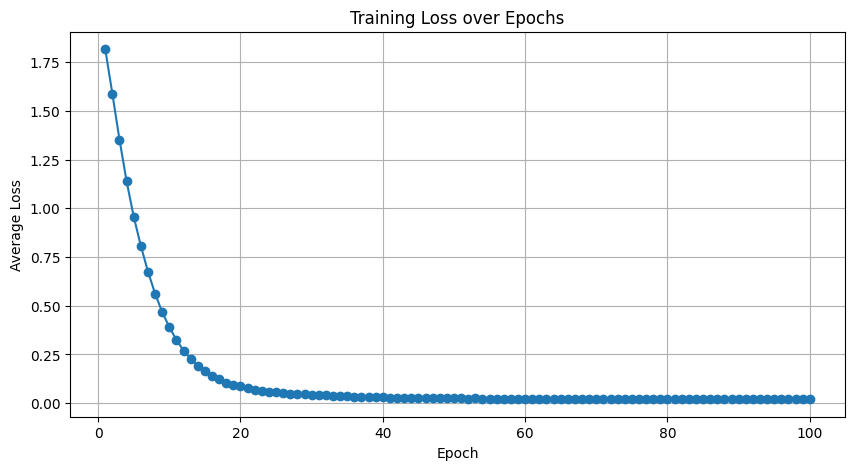

In [121]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), epoch_losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("Training Loss over Epochs")
plt.grid(True)
plt.show()